## **Multivariate Linear Regression, Non-Parametric Models and Cross-Validation**

Parth Patel - 8629824

**Imports**

In [157]:
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


## **Part 1**

### Get the Data

In [158]:
diabetes = datasets.load_diabetes(as_frame=True)
df = diabetes.frame
## independent variables
X = diabetes.data
## dependent variables
y = diabetes.target

df.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Frame the Problem

**Type:**   
Regression   

**Objective:**   
Predict disease progression one year after baseline   

**Use Case:**   
A tool to help physicians identify patients at risk of worsening diabetes

## EDA

### Explore

In [159]:
correlation_matrix = df.corr()

df.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680,0.586450
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430,0.441482
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212,0.430453
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669,0.565883
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000,0.382483


In [160]:
## we grabbed the three top features to display their scatterplots
top_features = correlation_matrix["target"].drop("target").abs().sort_values(ascending=False).head(3).index.tolist()


### Generate Plots

**Scatter Plots:**

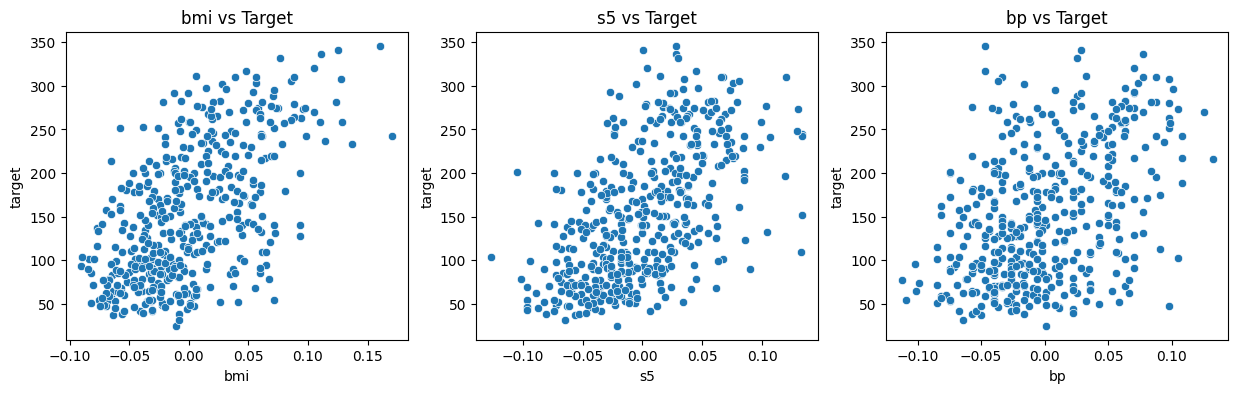

In [161]:
## do it in a loop to avoid repeating code

plt.figure(figsize=(15, 4))
for i, feature in enumerate(top_features):
    plt.subplot(1, 3, i+1)
    sns.scatterplot(data=df, x=feature, y="target")
    plt.title(f"{feature} vs Target")


plt.show()

**Histograms:**

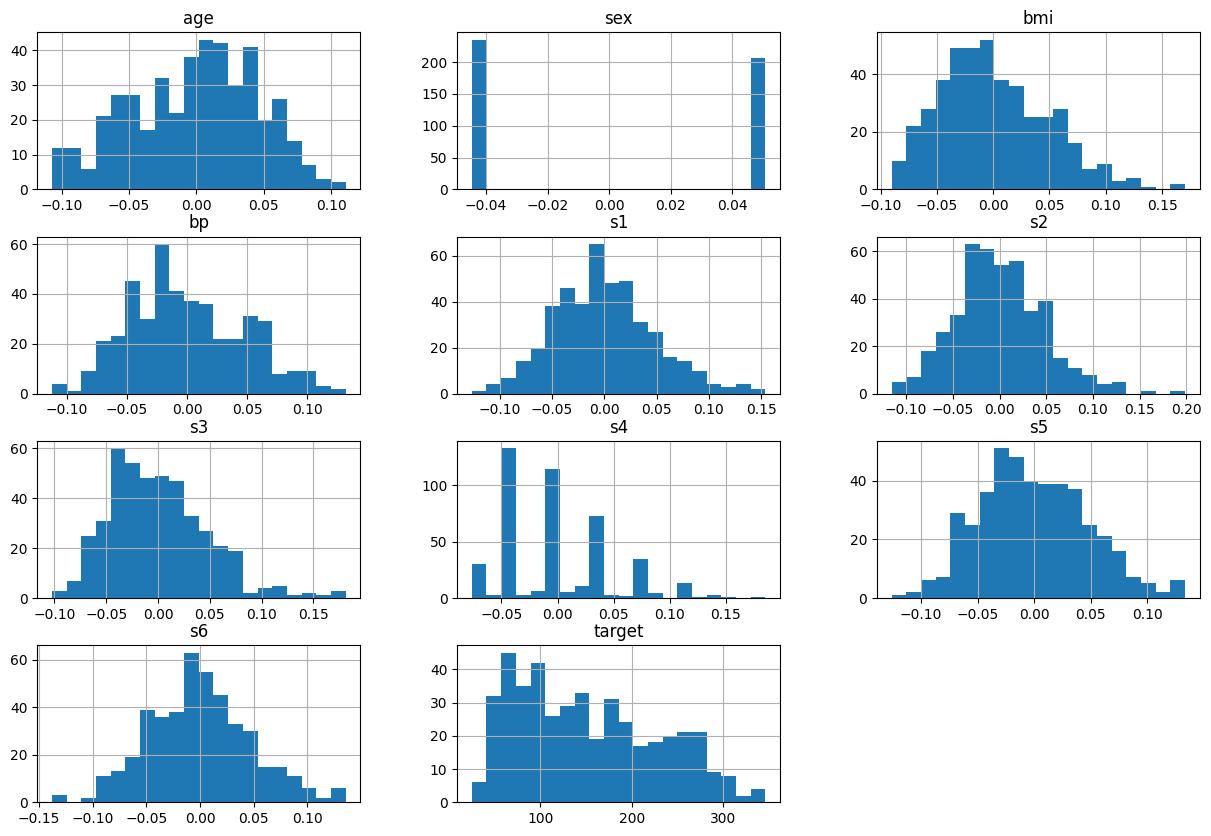

In [162]:
df.hist(bins=20, figsize=(15, 10))
plt.show()

**Heatmap:**

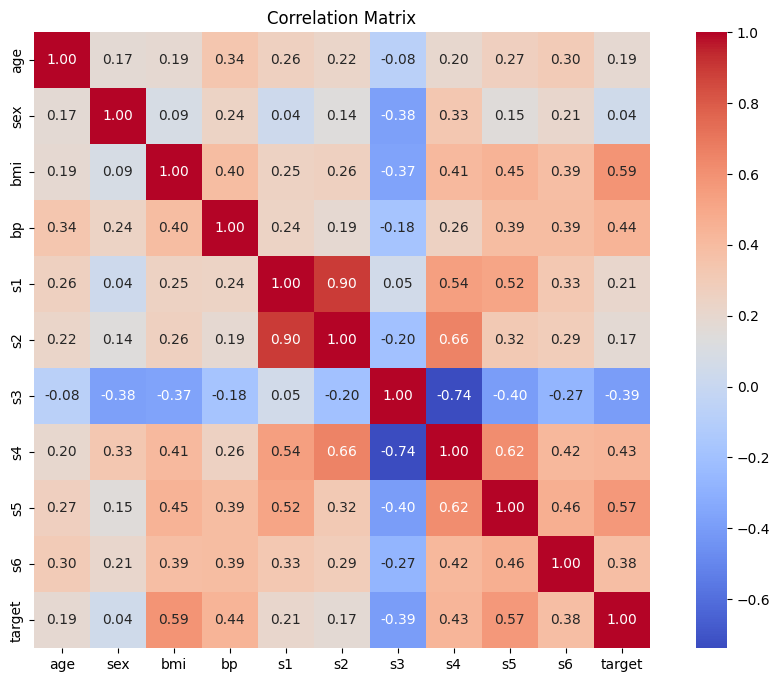

In [163]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Matrix")
plt.show()

**Statistics:**

In [164]:
df.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


### Describe

This is a data set with approximately 440 samples, this data contains ten different features namely: `age`, `sex`, `bmi`, `bp`, `s1`, `s2`, `s3`, `s4`, `s5`, `s6`,   

The target feature is disease progression after a year, it is a continuous variable with the follwing stats:
- mean -> 152.13
- standard deviation -> 77.09
- range -> 25 - 346

All features listed are standardized which means that they have a mean of 0.

### Insights

- From our analysis it appears bmi, s5, bp have the highest correlation with the target
- These three variables also showed a clear linear relationship with the target in the scatterplot
- Histogram displays a norm distribution for most variates and the target variate is right shifted


## Clean (if needed)

We can check if cleaning is required by checking duplicate values, null values, and checking for outliers using a box and whisket plot:

Null/Duplicate check:

In [165]:
print(df.isnull().sum())
print(df.duplicated().sum())

age       0
sex       0
bmi       0
bp        0
s1        0
s2        0
s3        0
s4        0
s5        0
s6        0
target    0
dtype: int64
0


No null and duplicate values were found.

Let's check for outliers:


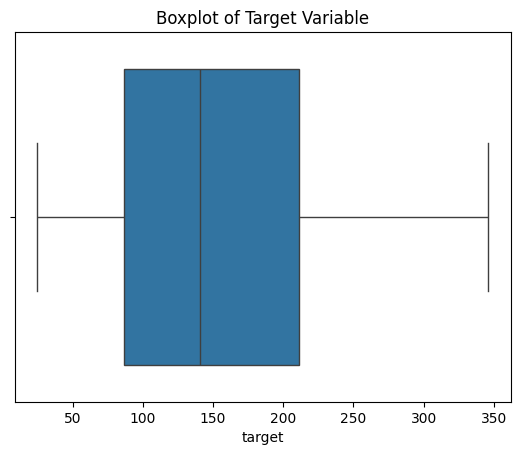

In [166]:
sns.boxplot(x=df["target"])
plt.title("Boxplot of Target Variable")
plt.show()

No outliers were found.

Therefore no cleaning is required.

## Split Data Into Train, Validation, and Test

In [167]:
## first get ride of target 
X = df.drop(columns=["target"])
y = df["target"]

## get the test set first

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


## now get the train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1176, random_state=42)

print(X_train.shape[0], "/442 -> 74.66%")
print(X_val.shape[0], "/442 -> 10.18%")
print(X_test.shape[0], "/442 -> 15.16%")

330 /442 -> 74.66%
45 /442 -> 10.18%
67 /442 -> 15.16%


## **Part 2: Univariate Polynomial Regression**

Let's run 6 models of degree 0 to 5:

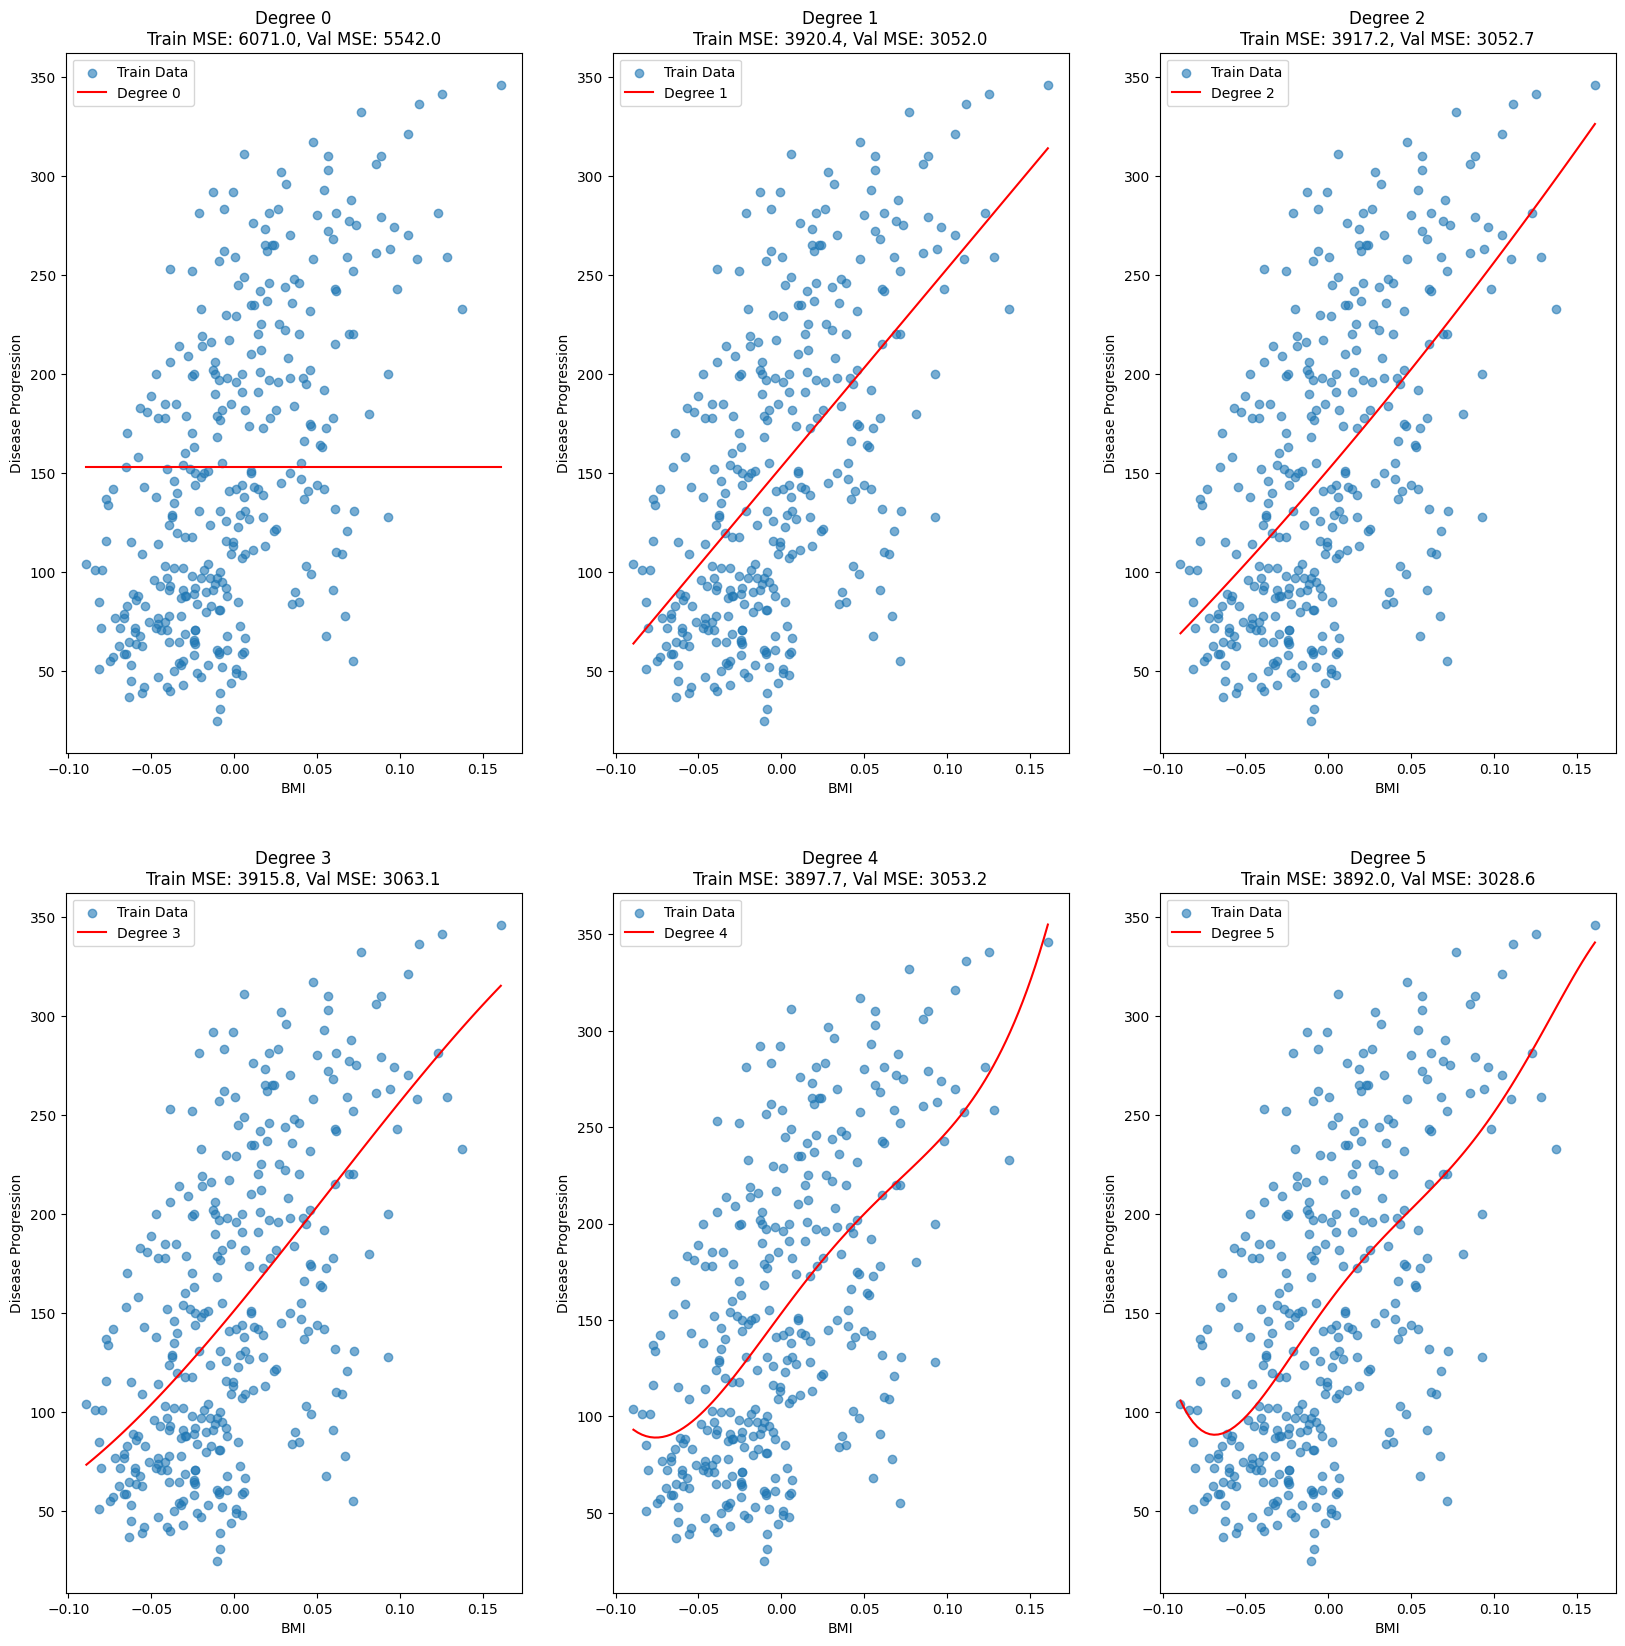

In [168]:
## We only need to do this on BMI so lets isolate that variable
X_train_bmi = X_train[["bmi"]].values
X_val_bmi = X_val[["bmi"]].values
y_train_bmi = y_train.values
y_val_bmi = y_val.values
results = []
degrees = range(6)
t_err = []
v_err = []
plt.figure(figsize=(20, 20))

## create a loop to do all the work 6 times
for i, degree in enumerate(degrees):
    ## set up the model and fit
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train_bmi)
    X_poly_val = poly.transform(X_val_bmi)
    model = LinearRegression()
    model.fit(X_poly_train, y_train_bmi)
    ## run the predications
    y_train_pred = model.predict(X_poly_train)
    y_val_pred = model.predict(X_poly_val)
    train_mse = mean_squared_error(y_train_bmi, y_train_pred)
    val_mse = mean_squared_error(y_val_bmi, y_val_pred)
    t_err.append(train_mse)
    v_err.append(val_mse)
    # predictions
    X_plot = np.linspace(X_train_bmi.min(), X_train_bmi.max(), 100).reshape(-1, 1)
    X_plot_poly = poly.transform(X_plot)
    y_plot = model.predict(X_plot_poly)
    ## create the plots
    plt.subplot(2, 3, i+1)
    plt.scatter(X_train_bmi, y_train_bmi, alpha=0.6, label="Train Data")
    plt.plot(X_plot, y_plot, color="red", label=f"Degree {degree}")
    plt.title(f"Degree {degree}\nTrain MSE: {train_mse:.1f}, Val MSE: {val_mse:.1f}")
    plt.xlabel("BMI")
    plt.ylabel("Disease Progression")
    plt.legend()
    # Gather the information rqeuired
    r2_train = r2_score(y_train_bmi, y_train_pred)
    mae_train = mean_absolute_error(y_train_bmi, y_train_pred)
    mape_train = np.mean(np.abs((y_train_bmi - y_train_pred) / y_train_bmi)) * 100

    r2_val = r2_score(y_val_bmi, y_val_pred)
    mae_val = mean_absolute_error(y_val_bmi, y_val_pred)
    mape_val = np.mean(np.abs((y_val_bmi - y_val_pred) / y_val_bmi)) * 100

    results.append({
        "Degree": degree,
        "Train R^2": round(r2_train, 3),
        "Train MAE": round(mae_train, 2),
        "Train MAPE (%)": round(mape_train, 2),
        "Val R^2": round(r2_val, 3),
        "Val MAE": round(mae_val, 2),
        "Val MAPE (%)": round(mape_val, 2)
    })

Show the results of R^2, MSE, MAPE

In [169]:
results_df = pd.DataFrame(results)
print(results_df)

   Degree  Train R^2  Train MAE  Train MAPE (%)  Val R^2  Val MAE  \
0       0      0.000      66.55           63.35   -0.000    63.45   
1       1      0.354      52.28           48.46    0.449    42.00   
2       2      0.355      52.27           48.45    0.449    41.76   
3       3      0.355      52.22           48.36    0.447    41.74   
4       4      0.358      51.94           47.96    0.449    41.95   
5       5      0.359      51.81           47.83    0.454    42.08   

   Val MAPE (%)  
0         58.79  
1         40.44  
2         40.31  
3         40.26  
4         40.24  
5         40.34  


### Best Model

Based on the table above, the degree 5 model has the highest validation R^2 (0.454) and maintains low MAE (42.08) and MAPE (40.34%), showing it had the best performance on the data. The degree 5 polynomial regression model offers the best trade-off between model complexity and predictive accuracy, achieving the highest R^2 on the validation set while keeping errors low.

### Run the Degree 5 Model on the Test Set

In [170]:
X_test_bmi = X_test[["bmi"]].values
y_test_bmi = y_test.values

# best modeedl is degree 5 polynomial model
best = PolynomialFeatures(degree=5)
X_poly_train = best.fit_transform(X_train_bmi)
X_poly_test = best.transform(X_test_bmi)

# train on full training
model_best = LinearRegression()
model_best.fit(X_poly_train, y_train_bmi)

# predict on test set
y_test_pred = model_best.predict(X_poly_test)

# compute metrics
r2_test = r2_score(y_test_bmi, y_test_pred)
mae_test = mean_absolute_error(y_test_bmi, y_test_pred)
mape_test = np.mean(np.abs((y_test_bmi - y_test_pred) / y_test_bmi)) * 100

# create a summary
test_results = {
    "Test R^2": round(float(r2_test), 3),
    "Test MAE": round(float(mae_test), 2),
    "Test MAPE (%)": round(float(mape_test), 2)
}

test_results


{'Test R^2': 0.197, 'Test MAE': 54.55, 'Test MAPE (%)': 47.88}

### Plot the Graph

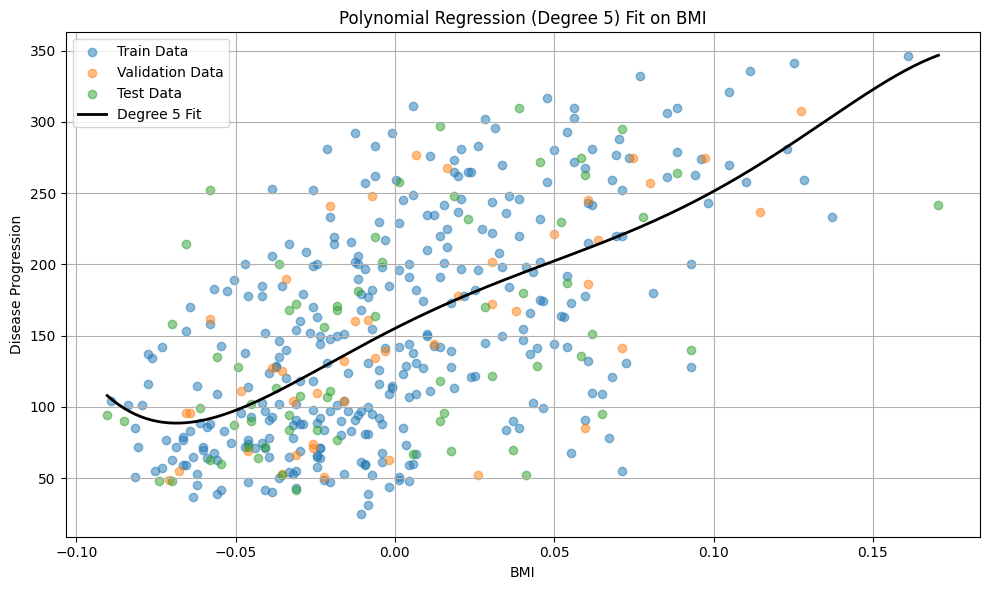

In [171]:
X_range = np.linspace(X["bmi"].min(), X["bmi"].max(), 300).reshape(-1, 1)
X_range_poly = best.transform(X_range)
y_range_pred = model_best.predict(X_range_poly)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(X_train_bmi, y_train_bmi, alpha=0.5, label="Train Data")
plt.scatter(X_val_bmi, y_val_bmi, alpha=0.5, label="Validation Data")
plt.scatter(X_test_bmi, y_test_bmi, alpha=0.5, label="Test Data")

plt.plot(X_range, y_range_pred, color="black", linewidth=2, label="Degree 5 Fit")

plt.xlabel("BMI")
plt.ylabel("Disease Progression")
plt.title("Polynomial Regression (Degree 5) Fit on BMI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Equation

In [172]:
coeffs = model_best.coef_
intercept = model_best.intercept_

terms = [f"{intercept:.2f}"]
for i, coef in enumerate(coeffs[1:], start=1):
    terms.append(f"{coef:.2f} * x^{i}")

terms

['155.08',
 '1131.59 * x^1',
 '-3946.02 * x^2',
 '-26110.86 * x^3',
 '768725.87 * x^4',
 '-2823251.97 * x^5']

$$
\hat{y} = 155.08 + 1131.59 \cdot x - 3946.02 \cdot x^2 - 26110.86 \cdot x^3 + 768725.87 \cdot x^4 - 2823251.97 \cdot x^5
$$


### Predict on -0.09

In [173]:
chosen_bmi_value = np.array([[-0.09]])

# transfomr the point
chosen_bmi_poly = best.transform(chosen_bmi_value)
# predict
predicted_progression = model_best.predict(chosen_bmi_poly)[0]

float(round(predicted_progression, 2))

107.42

### Quantifying Trainable Parameters

In [174]:
print("Degree | Number of Parameters | Feature Names")
for degree in range(6):
    poly = PolynomialFeatures(degree)
    poly.fit(X_train_bmi)
    features = poly.get_feature_names_out(["bmi"])
    print(f"{degree:^6} | {len(features):^21} | {features}")

Degree | Number of Parameters | Feature Names
  0    |           1           | ['1']
  1    |           2           | ['1' 'bmi']
  2    |           3           | ['1' 'bmi' 'bmi^2']
  3    |           4           | ['1' 'bmi' 'bmi^2' 'bmi^3']
  4    |           5           | ['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4']
  5    |           6           | ['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4' 'bmi^5']


This essentially means that for each degree (d) we have we can train d + 1 parameters. Each added degree adds another coefficient to fit which increases complexity, and also adds a risk of overfitting the data. In this case, adding more degrees may have caused us to lose some accuracy.

### Conclusion

We trained polynomial regression models of degree 0 through 5 using the BMI feature to predict diabetes progression (1 year after baseline) using the Scikit-Learn diabetes dataset. After evaluating models on training, validation, and test sets:

The degree 5 polynomial was selected as the best-performing model based on validation R^2 (0.454) and error metrics (MAE: 42.08, MAPE: 40.34%).

However, performance on the test set declined:

**Test R^2:** 0.197

**Test MAE:** 54.55

**Test MAPE:** 47.88%

This indicates a noticeable drop in generalization, hinting at overfitting.

**Model Failures:**

- The model’s validation and test metrics show diminishing gains despite higher degrees. The degree 5 model fits training data more precisely but does not translate this into significantly better real-world predictions.

- The model struggles with very low or very high progression scores, as seen from high residual errors in those regions. This is expected since it only uses BMI, which is insufficient to capture the complexity of diabetes progression.

- Low test R^2 indicates that a large portion of the variability in the target is unexplained by BMI alone, even with non-linear modeling.





**Model Limitations:**

- BMI alone cannot explain most of the variation in diabetes progression. Other clinical features like blood pressure, cholesterol, or glucose markers are critical for improved accuracy.

- High-degree polynomials can behave erratically outside the training data range, leading to poor predictions on edge cases.

## **Part 3: Two More Polynomial Models**

We will use all features

In [175]:
# all feature
X_train_full = X_train.values
X_val_full = X_val.values
X_test_full = X_test.values
y_train_full = y_train.values
y_val_full = y_val.values
y_test_full = y_test.values

# degrees for multivariate polynomial models
poly_degrees = [3, 4]
poly_results = []

for degree in poly_degrees:
    # create and fit model
    poly = PolynomialFeatures(degree)
    X_poly_train = poly.fit_transform(X_train_full)
    X_poly_val = poly.transform(X_val_full)
    X_poly_test = poly.transform(X_test_full)

    # train
    model = LinearRegression()
    model.fit(X_poly_train, y_train_full)

    # predict
    y_train_pred = model.predict(X_poly_train)
    y_val_pred = model.predict(X_poly_val)

    # metrics
    result = {
        "Degree": degree,
        "Train R^2": round(r2_score(y_train_full, y_train_pred), 3),
        "Train MAE": round(mean_absolute_error(y_train_full, y_train_pred), 2),
        "Train MAPE (%)": round(np.mean(np.abs((y_train_full - y_train_pred) / y_train_full)) * 100, 2),
        "Val R^2": round(r2_score(y_val_full, y_val_pred), 3),
        "Val MAE": round(mean_absolute_error(y_val_full, y_val_pred), 2),
        "Val MAPE (%)": round(np.mean(np.abs((y_val_full - y_val_pred) / y_val_full)) * 100, 2),

    }
    poly_results.append(result)

# results
pd.DataFrame(poly_results)

,Degree,Train R^2,Train MAE,Train MAPE (%),Val R^2,Val MAE,Val MAPE (%)
0,3,0.909,16.33,15.11,-115.945,287.18,193.21
1,4,1.000,0.00,0.00,-28.591,306.97,265.87


### Best Model

Degree 3 and 4 models massively overfit the training data (especially degree 4 with R^2 = 1.0 and zero error).

Both perform extremely poorly on validation and test sets, with huge errors and negative R^2, confirming that the models are not generalizing at all.

We will use the model with degree 3 as it is less poor performing than degree 4

### Run the Model (Degree 3)

In [176]:
X_train_full = X_train.values
X_test_full = X_test.values
y_train_full = y_train.values
y_test_full = y_test.values

# Best model is degree 3 polynomial model
best = PolynomialFeatures(degree=3)
X_poly_train = best.fit_transform(X_train_full)
X_poly_test = best.transform(X_test_full)

# Train on full training set
model_best = LinearRegression()
model_best.fit(X_poly_train, y_train_full)

# Predict on test set
y_test_pred = model_best.predict(X_poly_test)

# Compute metrics
r2_test = r2_score(y_test_full, y_test_pred)
mae_test = mean_absolute_error(y_test_full, y_test_pred)
mape_test = np.mean(np.abs((y_test_full - y_test_pred) / y_test_full)) * 100

# Create a summary
test_results_poly = {
    "Model": "Polynomial (deg=3)",
    "Test R^2": round(float(r2_test), 3),
    "Test MAE": round(float(mae_test), 2),
    "Test MAPE (%)": round(float(mape_test), 2)
}

test_results_poly

{'Model': 'Polynomial (deg=3)',
 'Test R^2': -101.137,
 'Test MAE': 282.7,
 'Test MAPE (%)': 241.25}

### Equation

In [177]:

# Fit a multivariate polynomial regression model of degree 3
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)
model = LinearRegression().fit(X_poly, y_train)

# Get feature names and coefficients
feature_names = poly.get_feature_names_out(X_train.columns)
coeffs = model.coef_
intercept = model.intercept_

# Build the equation
terms = [f"{intercept:.2f}"]
for name, coef in zip(feature_names[1:], coeffs[1:]):  # skip the intercept
    if abs(coef) >= 0.01:
        sign = "+" if coef >= 0 else "-"
        terms.append(f" {sign} {abs(coef):.2f}·{name}")

# Combine into equation string
equation = "y = " + " ".join(terms)
equation

'y = 5188.79  + 854.29·age  - 152752.62·sex  + 101383.32·bmi  - 397246.82·bp  - 600724.65·s1  + 715836.31·s2  + 166758.99·s3  - 79255.36·s4  - 188125.96·s5  - 28245.23·s6  - 6849.96·age^2  + 1079.69·age sex  + 23958.11·age bmi  - 8126.28·age bp  + 168398.55·age s1  - 136158.21·age s2  - 76627.08·age s3  - 28505.11·age s4  - 60242.07·age s5  + 8416.24·age s6  - 918.31·sex^2  + 11694.55·sex bmi  - 23417.04·sex bp  - 35199658.83·sex s1  + 30959548.25·sex s2  + 13142049.01·sex s3  - 52913.99·sex s4  + 11602031.59·sex s5  + 13156.93·sex s6  - 4073.42·bmi^2  - 11753.07·bmi bp  + 23387596.93·bmi s1  - 20585799.39·bmi s2  - 8698759.14·bmi s3  + 61343.31·bmi s4  - 7674743.35·bmi s5  - 22751.19·bmi s6  - 10540.93·bp^2  - 91859034.57·bp s1  + 80722647.73·bp s2  + 34344756.06·bp s3  + 21133.90·bp s4  + 30209435.99·bp s5  + 14636.75·bp s6  - 400168549.76·s1^2  + 747177719.21·s1 s2  + 285558764.61·s1 s3  - 18872535.31·s1 s4  + 169768723.17·s1 s5  - 6688168.71·s1 s6  - 347576179.32·s2^2  - 267315902.

### Predict on a Sample

In [178]:
sample_input_full = {
    "age": 0.03,
    "sex": -0.04,
    "bmi": 0.09,
    "bp": 0.05,
    "s1": -0.01,
    "s2": 0.02,
    "s3": 0.00,
    "s4": -0.03,
    "s5": 0.04,
    "s6": -0.01
}

# Convert to DataFrame
sample_df = pd.DataFrame([sample_input_full])

# Transform and predict
sample_poly = poly.transform(sample_df)
predicted_value = model.predict(sample_poly)[0]

float(round(predicted_value, 2))



-465450.41

severe overfitting is being shown in full here.

### Quantifying Trainable Parameters

In [179]:
for degree in [3, 4]:
    poly = PolynomialFeatures(degree)
    poly.fit(X_train)  # Only to generate feature names
    feature_names = poly.get_feature_names_out(X_train.columns)
    print(f"Degree {degree}: {len(feature_names)} trainable parameters")

Degree 3: 286 trainable parameters
Degree 4: 1001 trainable parameters


### Conclusion

We evaluated degree 3 and degree 4 multivariate polynomial regression models using all 10 standardized features from the Scikit-Learn diabetes dataset.

Degree 3 overfit the training data and completely failed to generalize.

Degree 4 perfectly fit the training data (R^2 = 1.0), but collapsed on validation and test sets.

**Model Failure:**

- Degree 3 and 4 generate hundreds to thousands of polynomial terms (286 and 1001 respectively). This leads to very
High computational cost and poorly conditioned models with very large or unstable coefficients

- Both models fit training data too tightly and show negative R^2 on unseen data, meaning they perform worse than simply predicting the mean.

- Model outputs were very large or negative, with the prediction going less than -450,000, which is not possible in a clinical setting.

**Model Limitations:**

- The models are sensitive to slight changes in input due to the polynomial complexity.

- With hundreds of features, it becomes difficult to extract meaningful clinical insights.

- These models are not robust and would be detrimental in a real-world healthcare setting.

## **Part 3: Decision Trees**

In [180]:
## use 3 and 5 as the max depth value
tree_configs = [3, 5]
tree_results = []

for depth in tree_configs:
    tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)

    # Predictions
    y_train_pred = tree.predict(X_train)
    y_val_pred = tree.predict(X_val)

    # Evaluation metrics
    result = {
        "Max Depth": depth,
        "Train R^2": round(r2_score(y_train, y_train_pred), 3),
        "Train MAE": round(mean_absolute_error(y_train, y_train_pred), 2),
        "Train MAPE (%)": round(np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100, 2),
        "Val R^2": round(r2_score(y_val, y_val_pred), 3),
        "Val MAE": round(mean_absolute_error(y_val, y_val_pred), 2),
        "Val MAPE (%)": round(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100, 2),

    }
    tree_results.append(result)

# Display results
pd.DataFrame(tree_results)

,Max Depth,Train R^2,Train MAE,Train MAPE (%),Val R^2,Val MAE,Val MAPE (%)
0,3,0.533,43.59,37.75,0.413,42.08,43.65
1,5,0.710,32.82,28.60,0.163,51.55,51.77


### Best Model

Both of these models actually perform relatively well, the shallower model has better validation perforamnce. The model with depth 5 actually has a higher r^2 on the train data but still performs well on the test data so we will use this as the "better model".

### Run the Model (Depth 5)

In [181]:
tree = DecisionTreeRegressor(max_depth=5, random_state=42)
tree.fit(X_train, y_train)

# Predict on test set
y_test_pred = tree.predict(X_test)

# Compute metrics
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Create summary
test_results_tree = {
    "Model": "Decision Tree (depth=5)",
    "Test R^2": round(float(r2_test), 3),
    "Test MAE": round(float(mae_test), 2),
    "Test MAPE (%)": round(float(mape_test), 2)
}

test_results_tree

{'Model': 'Decision Tree (depth=5)',
 'Test R^2': 0.327,
 'Test MAE': 47.98,
 'Test MAPE (%)': 39.91}

### Equation

Decision Trees do not follow an equation, they follow decision rules.

### Predict

In [182]:
sample_input_tree = {
    "age": 0.02,
    "sex": -0.04,
    "bmi": 0.04,
    "bp": 0.03,
    "s1": -0.02,
    "s2": 0.01,
    "s3": 0.00,
    "s4": -0.01,
    "s5": 0.05,
    "s6": 0.00
}

sample_df_tree = pd.DataFrame([sample_input_tree])

# Predict using decision tree model (depth=5)
predicted_progression = tree.predict(sample_df_tree)[0]

float(round(predicted_progression, 2))

158.0

This is a much better prediction in comparison to our polynomial models.

### Quantifying Trainable Parameters

A decision tree doesn’t have "parameters" in the traditional sense, but rather decision rules at nodes

Maximum number of nodes in a binary tree of depth d is:

2^d - 1   

2^5 - 1 = 31   

so we have 31 trainable parameters

### Conclusion

The Decision Tree Regressor with a maximum depth of 5 was trained to predict diabetes progression using all features. On the test set, it achieved:

R²: 0.33

MAE: 47.98

MAPE: 39.91%

This indicates a moderate level of predictive performance, with better generalization than polynomial models tested earlier.

**Model Failure:**   
- While it identifies general trends, it lacks fine tuned prediction accuracy. An MAE near 48 units is clinically significant.

- Limiting depth to 5 restricts the tree's ability to capture more complex patterns.

**Model Limitations:**   
- Different training/test splits could yield different trees.

- Unlike probabilistic models, it doesn’t express confidence in predictions.

- Small changes in data can lead to different tree structures.

## **Part 3: kNN's**

In [183]:
knn_configs = [2, 7]
knn_results = []

for k in knn_configs:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predictions
    y_train_pred = knn.predict(X_train)
    y_val_pred = knn.predict(X_val)

    # Metrics
    result = {
        "k": k,
        "Train R^2": round(r2_score(y_train, y_train_pred), 3),
        "Train MAE": round(mean_absolute_error(y_train, y_train_pred), 2),
        "Train MAPE (%)": round(np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100, 2),
        "Val R^2": round(r2_score(y_val, y_val_pred), 3),
        "Val MAE": round(mean_absolute_error(y_val, y_val_pred), 2),
        "Val MAPE (%)": round(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100, 2),

    }
    knn_results.append(result)

# Display results
pd.DataFrame(knn_results)

,k,Train R^2,Train MAE,Train MAPE (%),Val R^2,Val MAE,Val MAPE (%)
0,2,0.751,29.72,24.12,0.254,52.56,54.01
1,7,0.551,41.25,35.76,0.430,45.85,45.91


We can see that the k = 7 model is a better fit when looking at the validation results. So we will choose k = 7 model as our best fit.

### Run the Model (k=7)

In [184]:
knn_best = KNeighborsRegressor(n_neighbors=7)
knn_best.fit(X_train, y_train)

# Predict on test set
y_test_pred = knn_best.predict(X_test)

# Compute metrics
r2_test = r2_score(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# Create a summary
test_result_knn = {
    "Model": "kNN (k=7)",
    "Test R^2": round(float(r2_test), 3),
    "Test MAE": round(float(mae_test), 2),
    "Test MAPE (%)": round(float(mape_test), 2)
}

test_result_knn

{'Model': 'kNN (k=7)',
 'Test R^2': 0.386,
 'Test MAE': 44.99,
 'Test MAPE (%)': 39.35}

### Equation

The kNN learning model does not have a set equation like a polynomial regression does.

### Predict 

In [185]:
# sample pateint
sample_input_knn = pd.DataFrame([{
    "age": 0.02,
    "sex": -0.04,
    "bmi": 0.04,
    "bp": 0.03,
    "s1": -0.02,
    "s2": 0.05,
    "s3": 0.00,
    "s4": -0.08,
    "s5": 0.05,
    "s6": 0.00
}])

# Predict using the best kNN model (k=7)
predicted_progression = knn_best.predict(sample_input_knn)

# Return result
float(round(predicted_progression[0], 2))

207.57

for the chosen patient the target value is 207.57

### Quantifying Training Parameters

The kNN method does not use parameters at all it instead stores the entire training dataset and use that to create a neighours graph and produces the distance between the point of inquiry and all training points.

### Conclusion

The k-Nearest Neighbors (kNN) model with 
𝑘
=
7
k=7 provided the best balance of generalization and predictive performance among the models tested. On the test set:

R^2: 0.386

MAE: 44.99

MAPE: 39.35%

These results show that kNN is capable of making reasonable predictions of diabetes progression using all available features, especially for patients with typical or average characteristics.

**Model Failure:**   
- Slight variations in input can lead to very different neighbors, especially in sparse regions of the feature space.

- The model tends to underperform for edge cases or unusual patients, since it has no notion of extrapolating data.

- All features are treated equally which does not reflect their true importance. In reality some features are more important than others.

**Model Limitations:**   
- Prediction time increases with training size; not ideal for large-scale deployment without optimization.

- It memorizes data rather than learning patterns this means performance depends entirely on data density and quality.

- Poor scaling or irrelevant features can skew distance calculations and degrade performance.

## **Which Model is the Best?**

We will use the three criteria we have used through this report and showcase which model is the best. We have already taken the better of the 2 models we compared in each category now let's find the best of the best. First let's create a table.

In [186]:
comparison_df = pd.DataFrame([test_result_knn, test_results_poly, test_results_tree])

## after creating the data frame of the tuples lets create the sorted df and display the table
comparison_df_sorted = comparison_df.sort_values(by="Test R^2", ascending=False).reset_index(drop=True)

comparison_df_sorted

,Model,Test R^2,Test MAE,Test MAPE (%)
0,kNN (k=7),0.386,44.99,39.35
1,Decision Tree (depth=5),0.327,47.98,39.91
2,Polynomial (deg=3),-101.137,282.70,241.25


### Conclusion:


Among the models tested, kNN (k = 7) clearly outperforms the others:

- It has the highest R^2 (0.386), indicating the best predictive accuracy.

- It also shows the lowest error (MAE: 44.99, MAPE: 39.35).

- The Polynomial model (deg = 3) performs very poorly and suffers from extreme overfitting.

The Final Verdict: kNN (k = 7) is the most reliable and generalizable model for predicting diabetes progression on this dataset.